# *WORKING file:* Species abundance model
### Description:
Create a tutorial for a marine species abundance model in python. This notebook was created at the PACE Hackweek 2025. Our use-case will be with [NOAA NEFSC bottom trawl](https://www.fisheries.noaa.gov/new-england-mid-atlantic/science-data/2025-spring-bottom-trawl-survey-completed-northeast) data, specifically longfin squid.


![longfin squid!](https://img.freepik.com/free-vector/hand-drawn-squid-illustration_23-2149560574.jpg?semt=ais_hybrid&w=740&q=80)
### Authors: 
* Fredric Bonou  (UNSTIM/IRHOB)

### History:
>*8/4/25: notebook initialized*

In [3]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---- Load Data ----
url = "https://cwcgom.aoml.noaa.gov/erddap/griddap/noaa_aoml_9f9d_930a_255d"
ds = xr.open_dataset(url)

In [4]:
ds

<xarray.Dataset> Size: 49GB
Dimensions:          (time: 458, latitude: 3360, longitude: 2640)
Coordinates:
  * time             (time) datetime64[ns] 4kB 2024-04-09T12:00:00 ... 2025-0...
  * latitude         (latitude) float32 13kB 69.98 69.94 69.9 ... -69.94 -69.98
  * longitude        (longitude) float32 11kB -84.98 -84.94 ... 24.94 24.98
Data variables:
    prococcus_moana  (time, latitude, longitude) float32 16GB ...
    syncoccus_moana  (time, latitude, longitude) float32 16GB ...
    picoeuk_moana    (time, latitude, longitude) float32 16GB ...
Attributes: (12/71)
    _lastModified:                     2025-08-04T00:18:34.000Z
    cdm_data_type:                     Grid
    comment:                           This dataset is redistributed by Atlan...
    Conventions:                       CF-1.10, ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    ...                                ...
    temporal_range:                    7-hour
    time_coverage_end:                 2025-08-04T12:00:00Z
    time_coverage_start:               2024-04-09T12:00:00Z
    title:                             OCI L3 SMI, PACE MOANA DAILY; via Atla...
    Westernmost_Easting:               -84.97916
    westernmost_longitude:             -85.0

In [5]:
# Code to compute monthly mean from daily data
import xarray as xr

# Subset to region
lat_bounds = (10, 30)
lon_bounds = (-25, -10)

ds_subset = ds.sel(
    latitude=slice(*sorted(lat_bounds, reverse=True)),  # descending lat
    longitude=slice(*sorted(lon_bounds))                # ascending lon
)

# Use strftime instead of to_period
ds_subset.coords["month"] = ds_subset.time.dt.strftime("%Y-%m")

# Group and average
monthly_mean = ds_subset.groupby("month").mean(dim="time")


In [6]:
monthly_mean.to_netcdf("monthly_mean_subset.nc", compute=True)

In [7]:
monthly_mean

<xarray.Dataset> Size: 35MB
Dimensions:          (month: 17, latitude: 480, longitude: 360)
Coordinates:
  * latitude         (latitude) float32 2kB 29.98 29.94 29.9 ... 10.06 10.02
  * longitude        (longitude) float32 1kB -24.98 -24.94 ... -10.06 -10.02
  * month            (month) object 136B '2024-04' '2024-05' ... '2025-08'
Data variables:
    prococcus_moana  (month, latitude, longitude) float32 12MB 1.252e+05 ... nan
    syncoccus_moana  (month, latitude, longitude) float32 12MB 4.755e+03 ... nan
    picoeuk_moana    (month, latitude, longitude) float32 12MB 966.2 ... nan
Attributes: (12/71)
    _lastModified:                     2025-08-04T00:18:34.000Z
    cdm_data_type:                     Grid
    comment:                           This dataset is redistributed by Atlan...
    Conventions:                       CF-1.10, ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    ...                                ...
    temporal_range:                    7-hour
    time_coverage_end:                 2025-08-04T12:00:00Z
    time_coverage_start:               2024-04-09T12:00:00Z
    title:                             OCI L3 SMI, PACE MOANA DAILY; via Atla...
    Westernmost_Easting:               -84.97916
    westernmost_longitude:             -85.0

/tmp/ipykernel_2964/2181213336.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


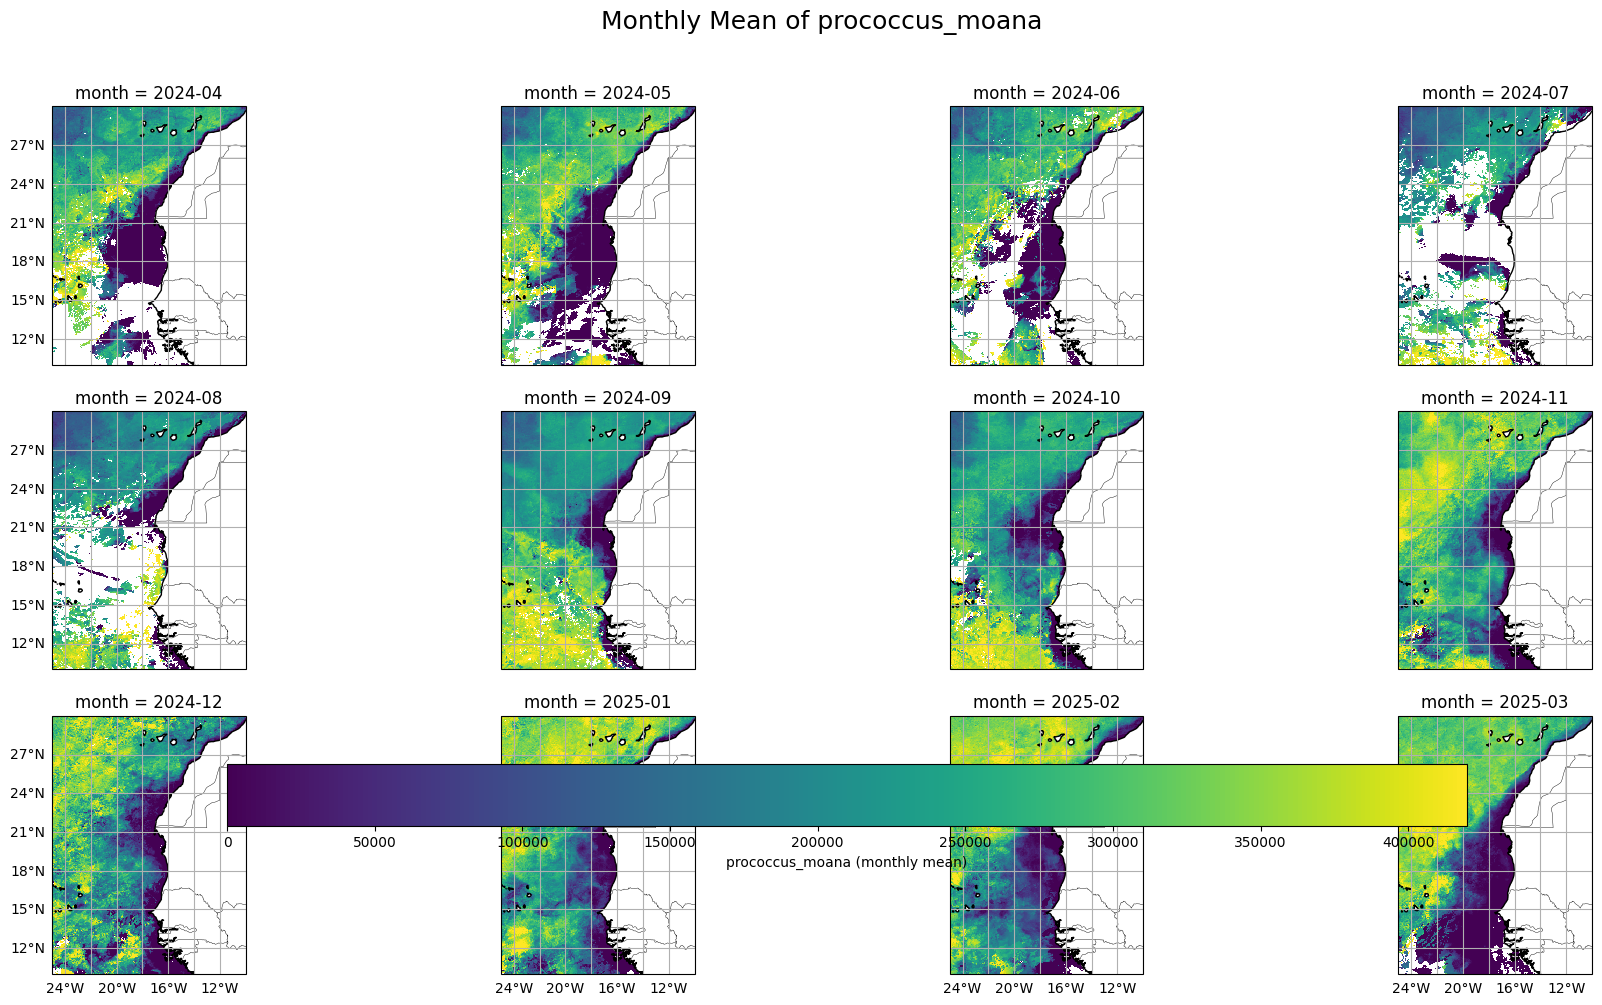

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# ---- Settings ----
variable = "prococcus_moana"
ds = monthly_mean  # your Dataset with time dimension labeled as datetime (not strings)

# ---- Create figure and axes ----
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# ---- Loop over months ----
for i, ax in enumerate(axs):
    # Select month i (0-based index)
    if i < len(ds.month):
        month_data = ds[variable].isel(month=i)

        ax.set_title(calendar.month_name[i + 1])
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
        gl.bottom_labels = i > 7
        gl.left_labels = i % 4 == 0
        gl.right_labels = False

        img = month_data.plot(
            ax=ax,
            cmap="viridis",
            robust=True,
            add_colorbar=False
        )
    else:
        ax.set_visible(False)

# ---- Add one colorbar for all ----
cbar = plt.colorbar(img, ax=axs, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label(f"{variable} (monthly mean)")

plt.suptitle(f"Monthly Mean of {variable}", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/tmp/ipykernel_2964/941966045.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


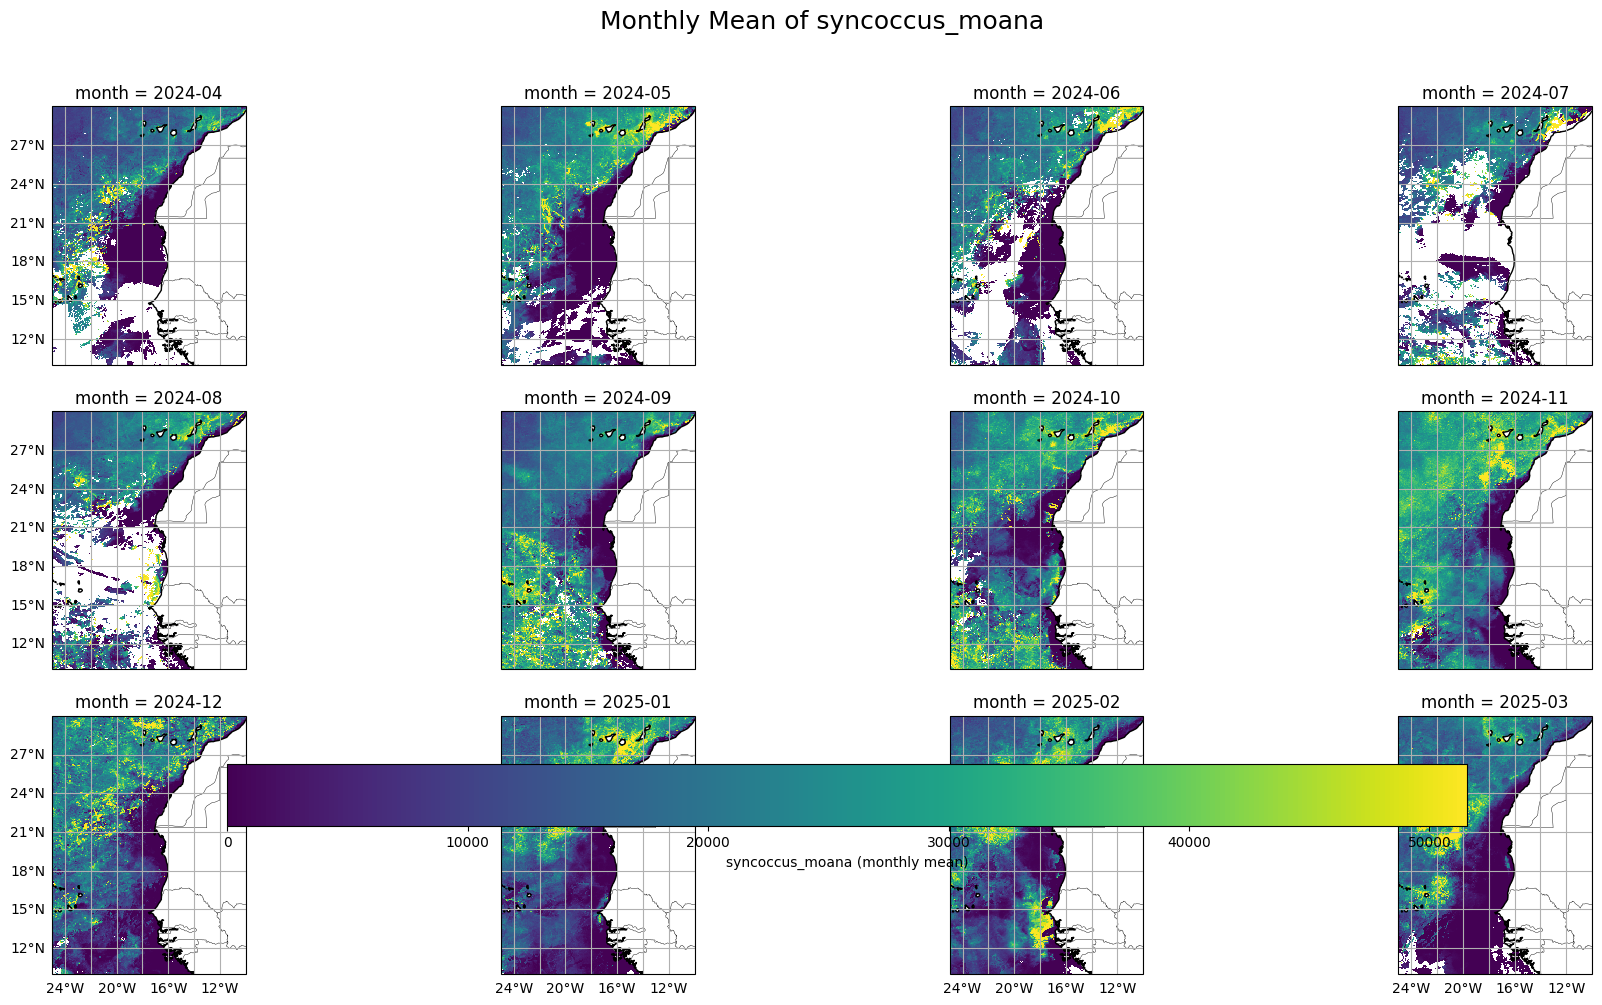

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# ---- Settings ----
variable = "syncoccus_moana"
ds = monthly_mean  # your Dataset with time dimension labeled as datetime (not strings)

# ---- Create figure and axes ----
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# ---- Loop over months ----
for i, ax in enumerate(axs):
    # Select month i (0-based index)
    if i < len(ds.month):
        month_data = ds[variable].isel(month=i)

        ax.set_title(calendar.month_name[i + 1])
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
        gl.bottom_labels = i > 7
        gl.left_labels = i % 4 == 0
        gl.right_labels = False

        img = month_data.plot(
            ax=ax,
            cmap="viridis",
            robust=True,
            add_colorbar=False
        )
    else:
        ax.set_visible(False)

# ---- Add one colorbar for all ----
cbar = plt.colorbar(img, ax=axs, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label(f"{variable} (monthly mean)")

plt.suptitle(f"Monthly Mean of {variable}", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/tmp/ipykernel_2964/3464896870.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


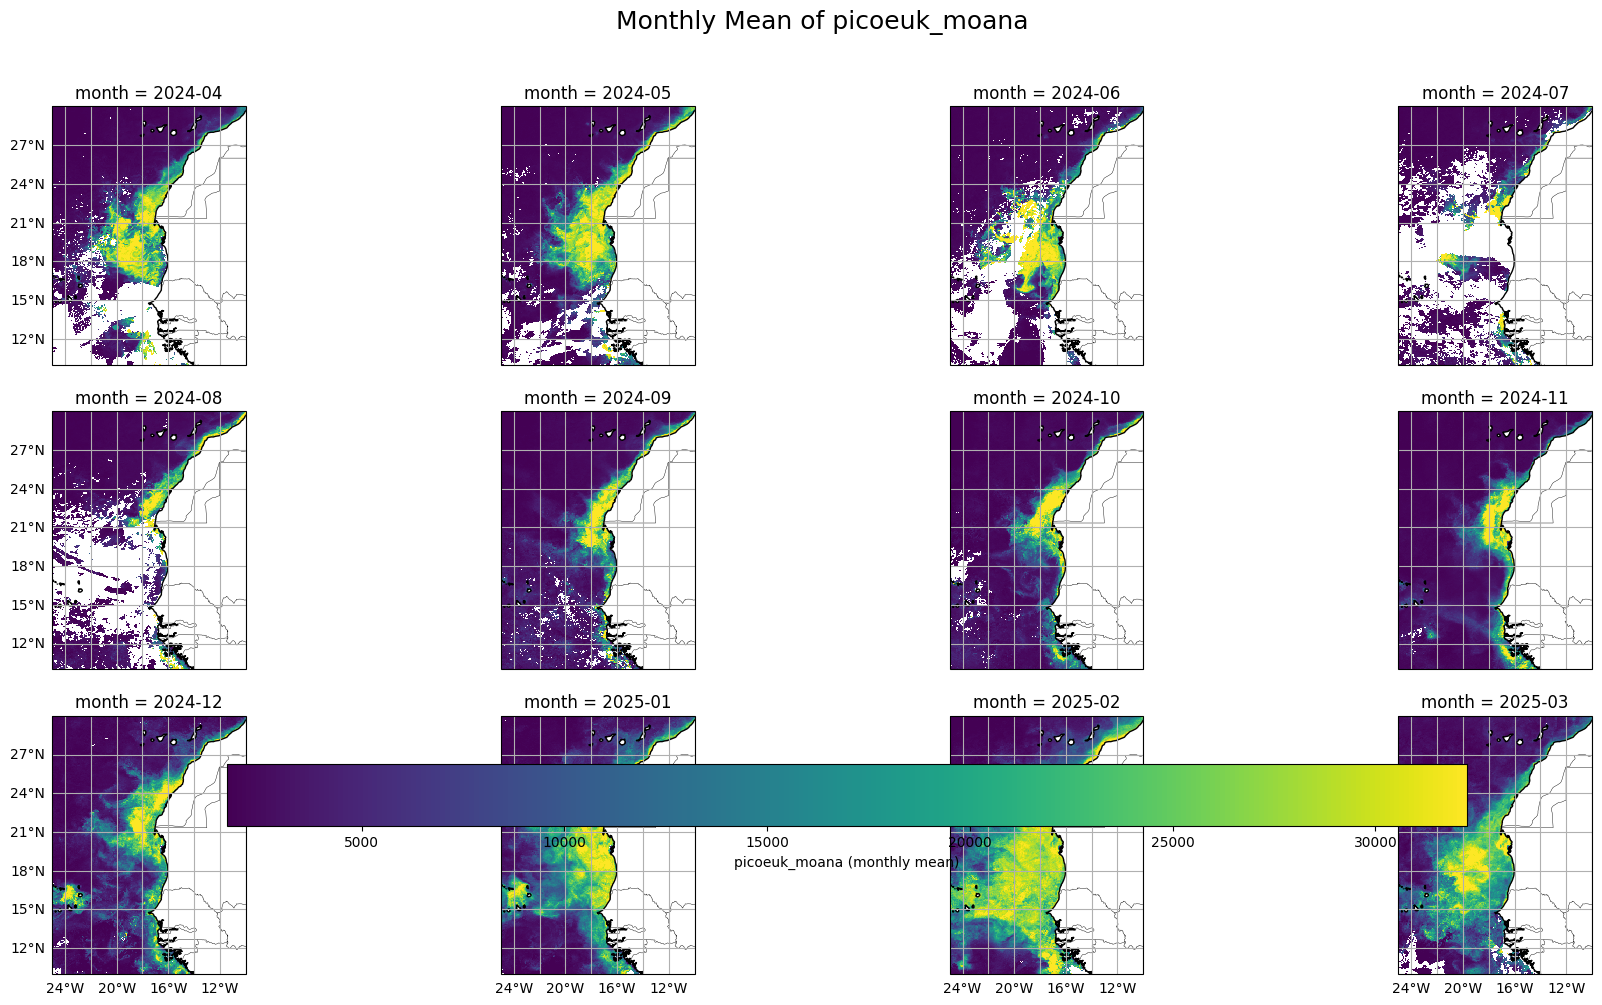

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# ---- Settings ----
variable = "picoeuk_moana"
ds = monthly_mean  # your Dataset with time dimension labeled as datetime (not strings)

# ---- Create figure and axes ----
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# ---- Loop over months ----
for i, ax in enumerate(axs):
    # Select month i (0-based index)
    if i < len(ds.month):
        month_data = ds[variable].isel(month=i)

        ax.set_title(calendar.month_name[i + 1])
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
        gl.bottom_labels = i > 7
        gl.left_labels = i % 4 == 0
        gl.right_labels = False

        img = month_data.plot(
            ax=ax,
            cmap="viridis",
            robust=True,
            add_colorbar=False
        )
    else:
        ax.set_visible(False)

# ---- Add one colorbar for all ----
cbar = plt.colorbar(img, ax=axs, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label(f"{variable} (monthly mean)")

plt.suptitle(f"Monthly Mean of {variable}", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:

import earthaccess 
import xarray as xr
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

short_name = 'AVHRR_OI-NCEI-L4-GLOB-v2.1'
results = earthaccess.search_data(
short_name = short_name,
)
len(results)

3502

In [12]:
#min_lon, min_lat, max_lon, max_lat = -25, 10, -10, 30

#date_range = ("2024-01-16", "2025-07-16")
date_range = ("2024-01-16", "2025-07-16")

# (xmin=-73.5, ymin=33.5, xmax=-43.5, ymax=43.5)
bbox = (-25, 10, -10, 30)
results = earthaccess.search_data(
    short_name = short_name,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox
)
len(results)



547

In [13]:
fileset = earthaccess.open(results[0:547])
ds1 = xr.open_mfdataset(fileset[0:547])

QUEUEING TASKS | :   0%|          | 0/547 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/547 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/547 [00:00<?, ?it/s]

In [14]:
ds1

<xarray.Dataset> Size: 9GB
Dimensions:           (time: 547, lat: 720, nv: 2, lon: 1440)
Coordinates:
  * lat               (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time              (time) datetime64[ns] 4kB 2024-01-15 ... 2025-07-16
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (time, lat, nv) float32 3MB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, lon, nv) float32 6MB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    mask              (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4_GHRSST-SSTblend-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

In [15]:
# Code to compute monthly mean from daily data
import xarray as xr

# Subset to region
lat_bounds = (10, 30)
lon_bounds = (-25, -10)

ds_subset1 = ds1.sel(
    lat=slice(*sorted(lat_bounds)),  # descending lat
    lon=slice(*sorted(lon_bounds))                # ascending lon
)

# Use strftime instead of to_period
ds_subset1.coords["month"] = ds_subset1.time.dt.strftime("%Y-%m")

# Group and average
monthly_mean1 = ds_subset1.groupby("month").mean(dim="time")


In [16]:
ds_subset1

<xarray.Dataset> Size: 43MB
Dimensions:           (time: 547, lat: 80, nv: 2, lon: 60)
Coordinates:
  * lat               (lat) float32 320B 10.12 10.38 10.62 ... 29.38 29.62 29.88
  * lon               (lon) float32 240B -24.88 -24.62 -24.38 ... -10.38 -10.12
  * time              (time) datetime64[ns] 4kB 2024-01-15 ... 2025-07-16
    month             (time) object 4kB '2024-01' '2024-01' ... '2025-07'
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (time, lat, nv) float32 350kB dask.array<chunksize=(1, 80, 2), meta=np.ndarray>
    lon_bnds          (time, lon, nv) float32 263kB dask.array<chunksize=(1, 60, 2), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float32 11MB dask.array<chunksize=(1, 80, 60), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 11MB dask.array<chunksize=(1, 80, 60), meta=np.ndarray>
    mask              (time, lat, lon) float32 11MB dask.array<chunksize=(1, 80, 60), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 11MB dask.array<chunksize=(1, 80, 60), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4_GHRSST-SSTblend-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

/tmp/ipykernel_2964/3029264149.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


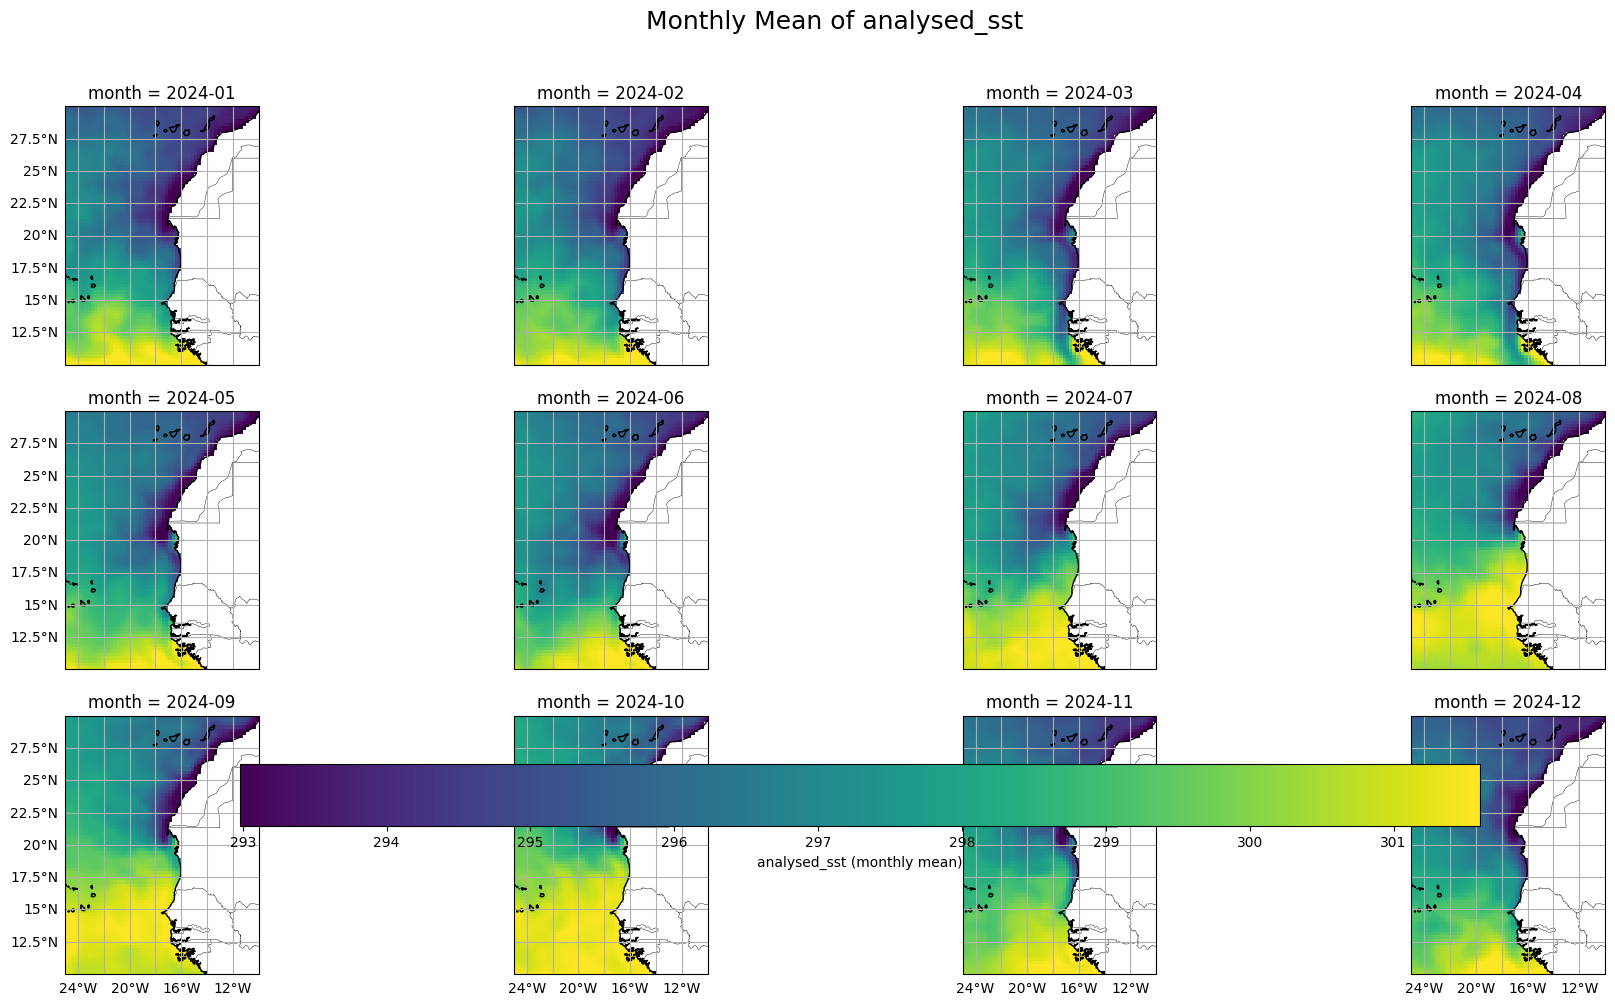

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# ---- Settings ----
variable = "analysed_sst"
ds1a = monthly_mean1  # your Dataset with time dimension labeled as datetime (not strings)

# ---- Create figure and axes ----
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# ---- Loop over months ----
for i, ax in enumerate(axs):
    # Select month i (0-based index)
    if i < len(ds1a.month):
        month_data1 = ds1a[variable].isel(month=i)

        ax.set_title(calendar.month_name[i + 1])
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
        gl.bottom_labels = i > 7
        gl.left_labels = i % 4 == 0
        gl.right_labels = False

        img = month_data1.plot(
            ax=ax,
            cmap="viridis",
            robust=True,
            add_colorbar=False
        )
    else:
        ax.set_visible(False)

# ---- Add one colorbar for all ----
cbar = plt.colorbar(img, ax=axs, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label(f"{variable} (monthly mean)")

plt.suptitle(f"Monthly Mean of {variable}", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [18]:
#short_name1 = 'SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5'
#short_name1 = 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6'
short_name1 = 'OISSS_L4_multimission_7day_v2'
#short_name1 = 'OISSS_L4_multimission_7day_v2'


results1 = earthaccess.search_data(
    short_name = short_name1,
    #count=3,
)
len(results1)

min_lon, min_lat, max_lon, max_lat = -25, 10, -10, 30

date_range = ("2024-01-16", "2025-07-16")
# (xmin=-73.5, ymin=33.5, xmax=-43.5, ymax=43.5)
bbox = (-25, 10, -10, 30)





In [19]:
results1 = earthaccess.search_data(
    short_name = short_name1,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
   # count=100
)
len(results1)

90

In [20]:
#ds1 = xr.open_dataset(fileset1[0])
fileset1 = earthaccess.open(results1[0:90])
ds2 = xr.open_mfdataset(fileset1[0:90])
ds2

QUEUEING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/90 [00:00<?, ?it/s]

<xarray.Dataset> Size: 2GB
Dimensions:                    (latitude: 720, longitude: 1440, time: 90)
Coordinates:
  * longitude                  (longitude) float32 6kB -179.9 -179.6 ... 179.9
  * latitude                   (latitude) float32 3kB -89.88 -89.62 ... 89.88
  * time                       (time) datetime64[ns] 720B 2024-01-12 ... 2025...
Data variables:
    sss                        (latitude, longitude, time) float64 746MB dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
    sss_empirical_uncertainty  (latitude, longitude, time) float64 746MB dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
    sss_formal_uncertainty     (latitude, longitude, time) float64 746MB dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v2
    Version:                       V2.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     0.25
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_lon_resolution:     0.25
    geospatial_lon_units:          degrees_east

In [21]:
ds2

<xarray.Dataset> Size: 2GB
Dimensions:                    (latitude: 720, longitude: 1440, time: 90)
Coordinates:
  * longitude                  (longitude) float32 6kB -179.9 -179.6 ... 179.9
  * latitude                   (latitude) float32 3kB -89.88 -89.62 ... 89.88
  * time                       (time) datetime64[ns] 720B 2024-01-12 ... 2025...
Data variables:
    sss                        (latitude, longitude, time) float64 746MB dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
    sss_empirical_uncertainty  (latitude, longitude, time) float64 746MB dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
    sss_formal_uncertainty     (latitude, longitude, time) float64 746MB dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v2
    Version:                       V2.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     0.25
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_lon_resolution:     0.25
    geospatial_lon_units:          degrees_east

In [22]:
# Code to compute monthly mean from daily data
import xarray as xr

# Subset to region
lat_bounds = (10, 30)
lon_bounds = (-25, -10)

ds_subset2 = ds2.sel(
    latitude=slice(*sorted(lat_bounds)),  # descending lat
    longitude=slice(*sorted(lon_bounds))                # ascending lon
)

# Use strftime instead of to_period
ds_subset2.coords["month"] = ds_subset2.time.dt.strftime("%Y-%m")

# Group and average
monthly_mean2 = ds_subset2.groupby("month").mean(dim="time")


In [23]:
monthly_mean2

<xarray.Dataset> Size: 1MB
Dimensions:                    (month: 13, latitude: 80, longitude: 60)
Coordinates:
  * longitude                  (longitude) float32 240B -24.88 -24.62 ... -10.12
  * latitude                   (latitude) float32 320B 10.12 10.38 ... 29.88
  * month                      (month) object 104B '2024-01' ... '2025-01'
Data variables:
    sss                        (month, latitude, longitude) float64 499kB dask.array<chunksize=(1, 80, 60), meta=np.ndarray>
    sss_empirical_uncertainty  (month, latitude, longitude) float64 499kB dask.array<chunksize=(1, 80, 60), meta=np.ndarray>
    sss_formal_uncertainty     (month, latitude, longitude) float64 499kB dask.array<chunksize=(1, 80, 60), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v2
    Version:                       V2.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     0.25
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_lon_resolution:     0.25
    geospatial_lon_units:          degrees_east

/tmp/ipykernel_2964/4172518341.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


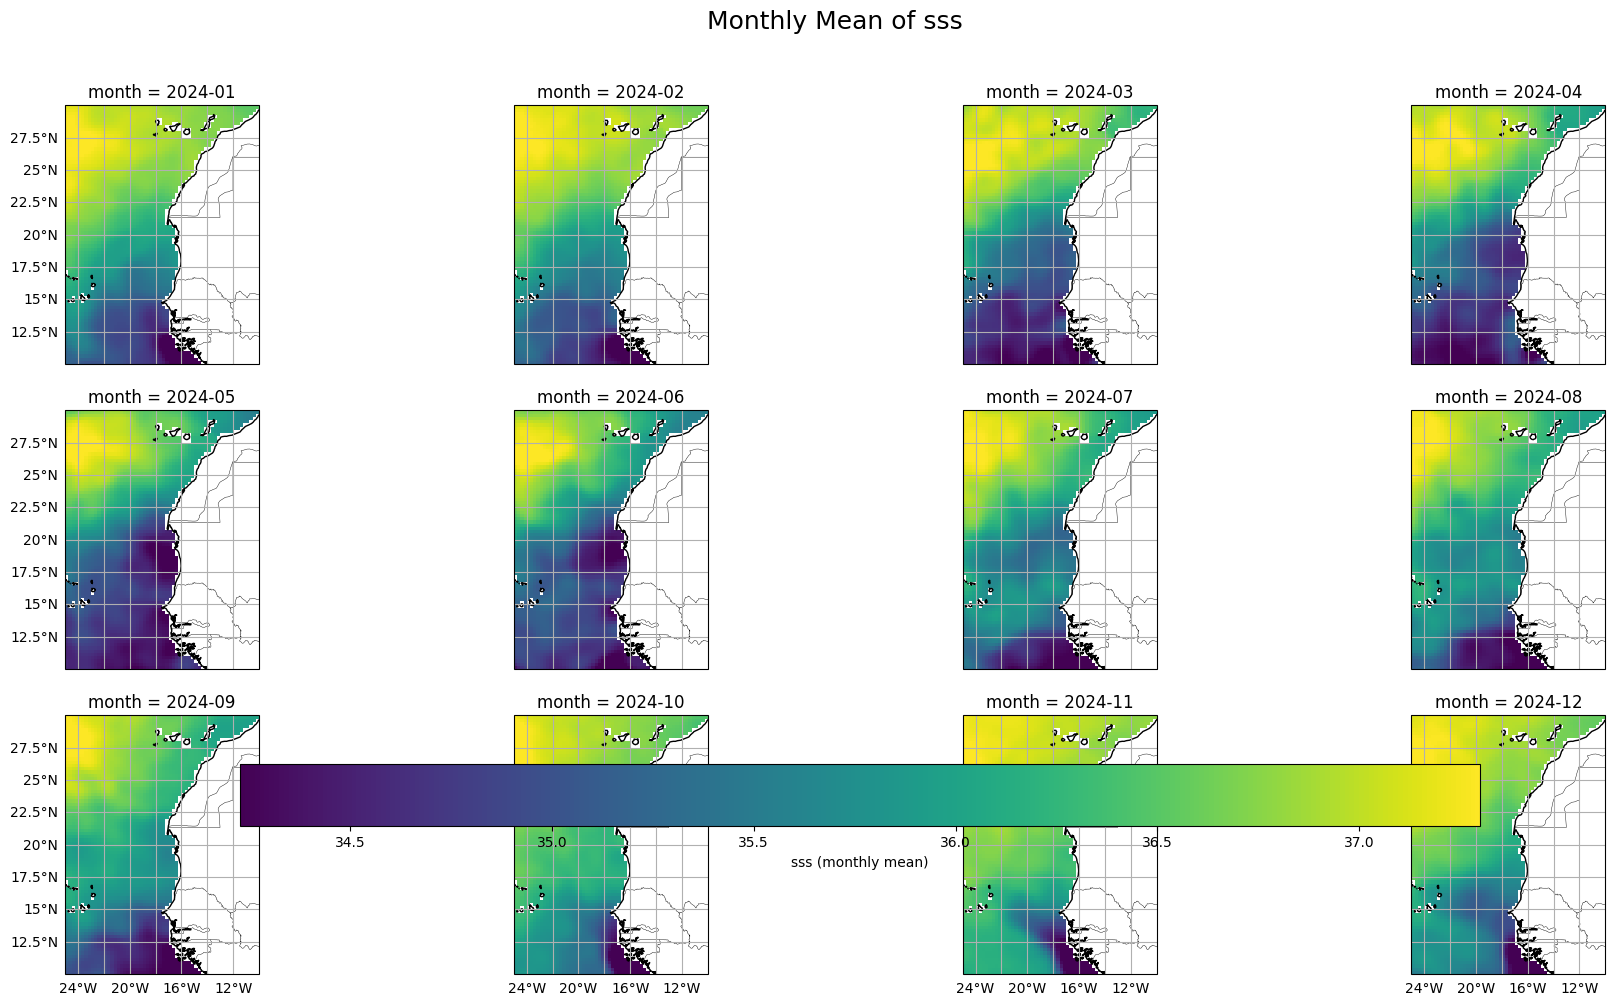

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# ---- Settings ----
variable = "sss"
ds2a = monthly_mean2  # your Dataset with time dimension labeled as datetime (not strings)

# ---- Create figure and axes ----
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# ---- Loop over months ----
for i, ax in enumerate(axs):
    # Select month i (0-based index)
    if i < len(ds2a.month):
        month_data2 = ds2a[variable].isel(month=i)

        ax.set_title(calendar.month_name[i + 1])
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
        gl.bottom_labels = i > 7
        gl.left_labels = i % 4 == 0
        gl.right_labels = False

        img = month_data2.plot(
            ax=ax,
            cmap="viridis",
            robust=True,
            add_colorbar=False
        )
    else:
        ax.set_visible(False)

# ---- Add one colorbar for all ----
cbar = plt.colorbar(img, ax=axs, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label(f"{variable} (monthly mean)")

plt.suptitle(f"Monthly Mean of {variable}", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [3]:
!pip install pyobis

In [26]:
#data.to_csv("~/proj_2025_sdm/contributors/fred/whales.csv", index=False)

In [4]:
import pyobis

def get_obis_data(species, geometry, startdate, enddate):
    occurrences = pyobis.occurrences.search(
        scientificname=species,
        geometry=geometry,
        fields=["id","scientificName", "decimalLatitude", "decimalLongitude", "eventDate"],
        startdate=startdate,
        enddate=enddate
    )
    return occurrences.execute()

#species = "Sardinella aurita"
species = "Larus fuscus"
startdate = "2023-01-01"
enddate = "2025-12-31"
min_lon, min_lat, max_lon, max_lat = -25, -35, 20, 35
geometry_wkt = f'POLYGON(({min_lon} {min_lat}, {max_lon} {min_lat}, {max_lon} {max_lat}, {min_lon} {max_lat}, {min_lon} {min_lat}))'  # WKT for bounding box
data = get_obis_data(species, geometry_wkt, startdate, enddate)
data

2025-08-06 17:24:19 - pyobis.obisutils - INFO - 71552 to be fetched. Estimated time =2.517600957155228905 seconds
2025-08-06 17:24:19 - pyobis.obisutils - INFO - Fetching: [█████████████.......................................................................................] 10000/71552
2025-08-06 17:24:27 - pyobis.obisutils - INFO - Fetching: [███████████████████████████.........................................................................] 20000/71552
2025-08-06 17:24:31 - pyobis.obisutils - INFO - Fetching: [█████████████████████████████████████████...........................................................] 30000/71552
2025-08-06 17:24:34 - pyobis.obisutils - INFO - Fetching: [███████████████████████████████████████████████████████.............................................] 40000/71552
2025-08-06 17:24:37 - pyobis.obisutils - INFO - Fetching: [█████████████████████████████████████████████████████████████████████...............................] 50000/71552
2025-08-06 17:24:40 -

decimalLatitude  decimalLongitude             eventDate scientificName  \
0            33.603191         -7.608983  2023-01-17T22:02:47Z   Larus fuscus   
1            33.574802         -7.619838  2023-12-15T00:00:57Z   Larus fuscus   
2            29.821079        -10.113170  2023-03-27T09:01:06Z   Larus fuscus   
3            27.094051        -13.419697  2023-01-30T23:00:26Z   Larus fuscus   
4            33.209049         -8.485875  2023-02-21T05:03:08Z   Larus fuscus   
...                ...               ...                   ...            ...   
71547        33.605679         -7.606200  2023-01-04T23:09:29Z   Larus fuscus   
71548        27.937101        -12.324576  2023-08-26T03:01:52Z   Larus fuscus   
71549        27.078747        -13.411431  2023-09-17T07:08:34Z   Larus fuscus   
71550        23.672207        -15.960562  2023-01-14T22:01:45Z   Larus fuscus   
71551        20.917387        -17.039370  2023-02-01T18:00:22Z   Larus fuscus   

                                         id  
0      0000cb8a-96f9-4965-b904-2e573f895db9  
1      00011b0f-a121-438d-8e2f-57c3a9100886  
2      0002dd07-fe61-4a29-b88f-9ce61748e54f  
3      0004807c-5f0a-448c-817b-5e0943406f31  
4      000596cf-de8d-47f5-99be-8c7aedcdf3be  
...                                     ...  
71547  fffc10d0-142e-416f-90ea-ea9ce877bfb7  
71548  fffc1e56-fadc-42dc-bef5-3dcf54e78623  
71549  fffcb987-9b76-4846-bfb3-b2c79bd8b003  
71550  fffddacc-cad8-48d0-9476-52f535882e9a  
71551  fffea554-83e6-4713-843a-0d754a105e50  

[71552 rows x 5 columns]

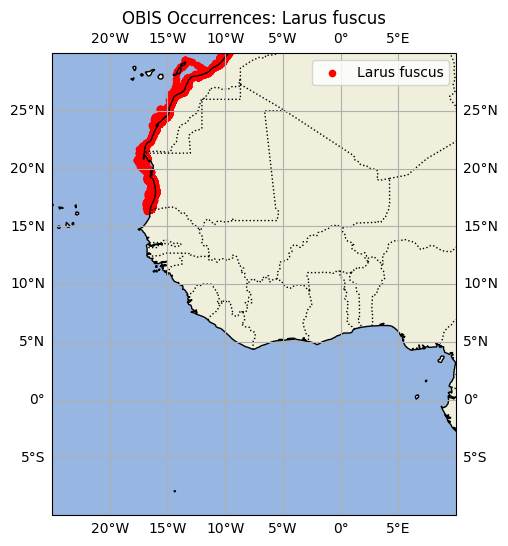

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

species = "Larus fuscus"
min_lon, max_lon, min_lat, max_lat = [-25, 10, -10, 30]

#species = "Megaptera novaeangliae"

data_clean = data[data["scientificName"] == species]

# Drop rows with missing coordinates
data_clean = data_clean.dropna(subset=["decimalLatitude", "decimalLongitude"])

# Extract lat/lon
lats = data_clean["decimalLatitude"]
lons = data_clean["decimalLongitude"]

# Create plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.LAND, zorder=0)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# Set bounding box
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Plot points
ax.scatter(lons, lats, color="red", s=20, transform=ccrs.PlateCarree(), label=species)

# Title and legend
ax.set_title(f"OBIS Occurrences: {species}")
ax.legend(loc="upper right")

plt.show()



In [6]:
top_species = data["scientificName"].value_counts().head(20)
print(top_species)

scientificName
Larus fuscus    71552
Name: count, dtype: int64


In [7]:
# Step 1: Make a copy and parse dates safely
import pandas as pd
ethmalosa_data = data[data["scientificName"] == "Ethmalosa fimbriata"].copy()
ethmalosa_data["eventDate"] = pd.to_datetime(ethmalosa_data["eventDate"], errors="coerce")

In [8]:
ethmalosa_data

Empty DataFrame
Columns: [decimalLatitude, decimalLongitude, eventDate, scientificName, id]
Index: []

In [33]:

#occurrences_by_year = (
#    ethmalosa_data
#    .dropna(subset=["eventDate"])  # filter out rows with NaT
#   .assign(year=lambda df: df["eventDate"].dt.year)
#    .groupby("year")
#    .size()
#    .sort_index()
#)

#import matplotlib.pyplot as plt

#occurrences_by_year.plot(kind="bar", figsize=(10, 4), title="Ethmalosa fimbriata Occurrences by Year")
#plt.xlabel("Year")
#plt.ylabel("Number of Records")
#plt.tight_layout()
#plt.show()


In [9]:
# Step 1: Ensure eventDate is datetime
data["eventDate"] = pd.to_datetime(data["eventDate"], errors="coerce")

# Step 2: Drop rows with missing dates or species
#data_clean = data.dropna(subset=["eventDate", "scientificName"])

data_clean = data

# Step 3: Extract year column
data_clean["year"] = data_clean["eventDate"].dt.year

# Step 4: Create species-by-year table
species_year_table = (
    data_clean
    .groupby(["scientificName", "year"])
    .size()
    .unstack(fill_value=0)
    .sort_index()  # Sort by species
)

# Display
import pandas as pd
#pd.set_option("display.max_rows", 20)  # or None to show all
species_year_table


year            2023.0
scientificName        
Larus fuscus     71551

In [10]:
data_clean.scientificName.unique()

array(['Larus fuscus'], dtype=object)

In [11]:
data_clean.groupby(["scientificName", "year"]).size()

scientificName  year  
Larus fuscus    2023.0    71551
dtype: int64

In [12]:
import pandas as pd
import calendar

# Step 1: Ensure datetime
data["eventDate"] = pd.to_datetime(data["eventDate"], errors="coerce")

# Step 2: Drop rows with missing species or date
data_clean = data.dropna(subset=["eventDate", "scientificName"]).copy()

# Step 3: Extract year and month
data_clean["year"] = data_clean["eventDate"].dt.year
data_clean["month"] = data_clean["eventDate"].dt.month

# Step 4: Count occurrences per species per year+month
monthly_counts = (
    data_clean
    .groupby(["scientificName", "year", "month"])
    .size()
    .reset_index(name="count")
)

# Step 5: Average count across years → monthly average per species
monthly_avg = (
    monthly_counts
    .groupby(["scientificName", "month"])["count"]
    .mean()
    .unstack(fill_value=0)  # Rows = species, columns = month
)

monthly_avg.columns = [calendar.month_abbr[m] for m in monthly_avg.columns]
monthly_avg = monthly_avg.round(1)  # Round for clarity

# Show the first few rows
monthly_avg.head()


Jan      Feb      Mar     Apr    Aug     Sep     Oct  \
scientificName                                                             
Larus fuscus    16948.0  14467.0  12321.0  2323.0  809.0  3371.0  3720.0   

                   Nov      Dec  
scientificName                   
Larus fuscus    5925.0  11667.0

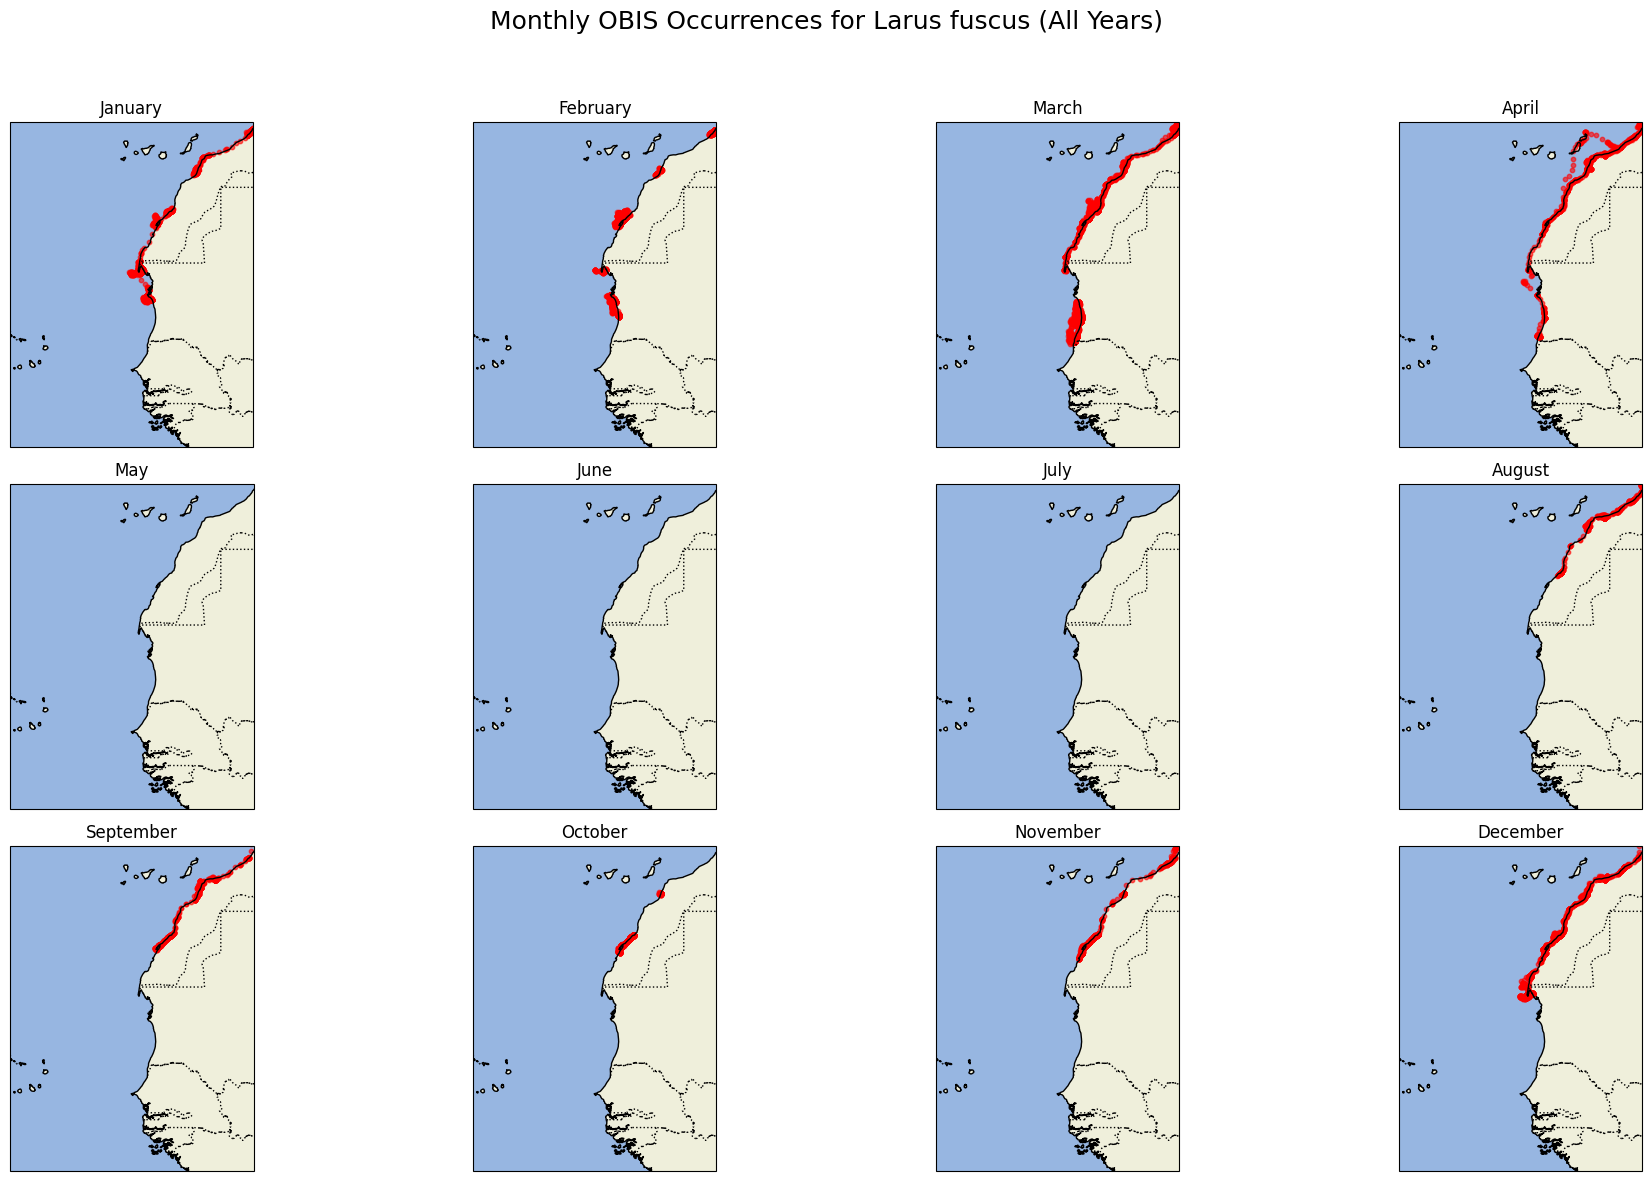

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# Make sure eventDate is datetime
data["eventDate"] = pd.to_datetime(data["eventDate"], errors="coerce")

min_lon, min_lat, max_lon, max_lat = [-25, 10, -10, 30]


# Filter for species
species = "Larus fuscus"
data_clean = (
    data[data["scientificName"] == species]
    .dropna(subset=["decimalLatitude", "decimalLongitude", "eventDate"])
    .copy()
)

# Extract month
data_clean["month"] = data_clean["eventDate"].dt.month

# Plot setup: 3 rows × 4 columns
fig, axes = plt.subplots(3, 4, figsize=(20, 12),
                         subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

# Loop over months
for month in range(1, 13):
    ax = axes[month - 1]
    month_data = data_clean[data_clean["month"] == month]

    # Set extent for your region
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Base map
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(calendar.month_name[month])

    # Plot points
    ax.scatter(
        month_data["decimalLongitude"],
        month_data["decimalLatitude"],
        color="red", s=10, alpha=0.6, transform=ccrs.PlateCarree()
    )

# Final layout
plt.suptitle(f"Monthly OBIS Occurrences for {species} (All Years)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# load Kd data

In [ ]:
## loading Kd

In [14]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

2025-08-06 17:26:18 - earthaccess.auth - INFO - You're now authenticated with NASA Earthdata Login


In [31]:
results3 = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    temporal = ("2024-01-01", "2024-07-31"),
   granule_name="*.MO.*.0p1deg.*"
)
len(results3)

2025-08-06 17:45:26 - earthaccess.api - INFO - Granules found: 5


5

In [32]:
# Create a fileset
fileset = earthaccess.open(results3);

2025-08-06 17:45:43 - earthaccess.store - INFO - Opening 5 granules, approx size: 0.25 GB
2025-08-06 17:45:43 - earthaccess.store - INFO - using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
# load the dataset
import xarray as xr
dataset = xr.open_dataset(fileset[0])
dataset

<xarray.Dataset> Size: 493MB
Dimensions:     (lat: 1800, lon: 3600, wavelength: 19, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Kd          (lat, lon, wavelength) float32 492MB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.KD.V...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/KD/3.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3010346
    data_minimum:                      0.015999997
    data_maximum:                      6.000002

In [34]:
dataset.Kd

<xarray.DataArray 'Kd' (lat: 1800, lon: 3600, wavelength: 19)> Size: 492MB
[123120000 values with dtype=float32]
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Attributes:
    long_name:      Diffuse attenuation coefficient
    units:          m^-1
    valid_min:      50
    valid_max:      30000
    reference:      Lee, Z.P., M. Darecki, K.L. Carder, C.O.Davis, D. Stramsk...
    display_scale:  log
    display_min:    0.01
    display_max:    5.0

In [84]:
short_name3="PACE_OCI_L3M_KD"
date ="2024-01-01", "2025-02-28"
bbox = (-25, 10, -10, 30)
results3 = earthaccess.search_data(
    short_name = short_name3,
    cloud_hosted = True,
    temporal = date,
    bounding_box = bbox,
    granule_name="*.MO.*.0p1deg.*nc"

   # count=100
)
len(results3)

2025-08-06 18:10:21 - earthaccess.api - INFO - Granules found: 12


12

In [85]:

paths = earthaccess.open(results3)

2025-08-06 18:10:44 - earthaccess.store - INFO - Opening 12 granules, approx size: 0.63 GB
2025-08-06 18:10:44 - earthaccess.store - INFO - using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
combine= {}

In [86]:
fileset3 = earthaccess.open(results3)
print(fileset3)


2025-08-06 18:10:45 - earthaccess.store - INFO - Opening 12 granules, approx size: 0.63 GB
2025-08-06 18:10:45 - earthaccess.store - INFO - using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240401_20240430.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240501_20240531.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240601_20240630.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240701_20240731.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240801_20240831.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240901_20240930.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20241001_20241031.L3m.MO.KD.V3_0.Kd.0p1deg.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20241101_20241130.L3m.MO.KD.V3_0.Kd.0p1

In [128]:
ds3 = xr.open_mfdataset(
    fileset3,
    combine='nested',
    concat_dim='time'
)


PermissionError: The provided token has expired.

In [109]:
ds3

<xarray.Dataset> Size: 6GB
Dimensions:     (time: 12, lat: 1800, lon: 3600, wavelength: 19, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: time, rgb, eightbitcolor
Data variables:
    Kd          (time, lat, lon, wavelength) float32 6GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 9kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.KD.V...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/KD/3.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3010346
    data_minimum:                      0.015999997
    data_maximum:                      6.000002

In [120]:
monthly_mean3=monthly_mean3.mean(dim="wavelength")

In [127]:

ds3a

<xarray.DataArray 'Kd' (lat: 0, lon: 150, wavelength: 19)> Size: 0B
dask.array<getitem, shape=(0, 150, 19), dtype=float32, chunksize=(0, 150, 8), chunktype=numpy.ndarray>
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 0B 
  * lon         (lon) float32 600B -24.95 -24.85 -24.75 ... -10.25 -10.15 -10.05
Attributes:
    long_name:      Diffuse attenuation coefficient
    units:          m^-1
    valid_min:      50
    valid_max:      30000
    reference:      Lee, Z.P., M. Darecki, K.L. Carder, C.O.Davis, D. Stramsk...
    display_scale:  log
    display_min:    0.01
    display_max:    5.0

TypeError: No numeric data to plot.

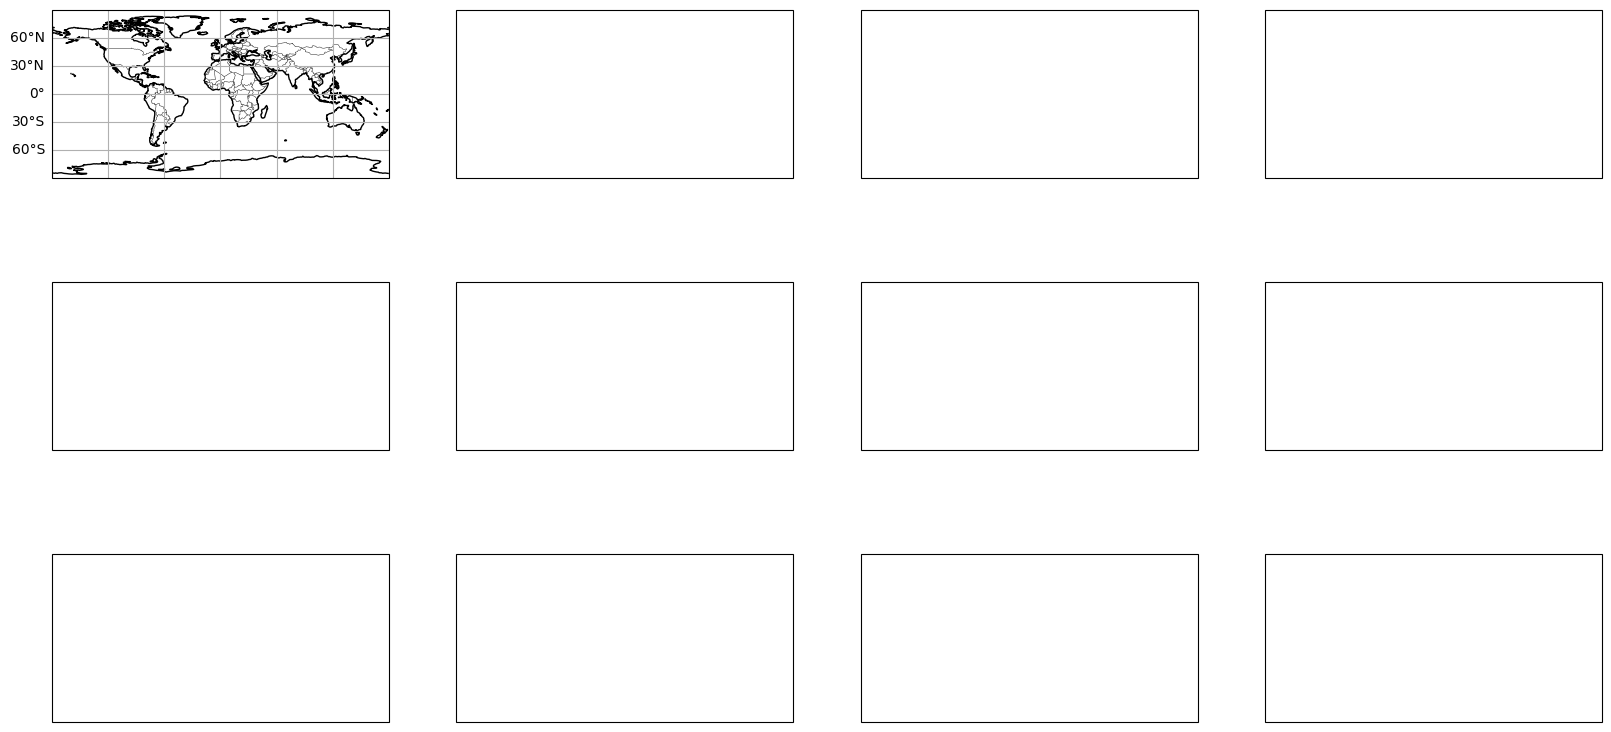

In [126]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

# ---- Settings ----
variable = "Kd"
#ds3a = monthly_mean3  # your Dataset with time dimension labeled as datetime (not strings)
#ds3a=ds3.sel(dim=1)
ds3a = ds3.isel(wavelength=0)  # Replace 'dim_name' with the actual name
ds3a = ds3.sel(
    lat=slice(*sorted(lat_bounds)),  # descending lat
    lon=slice(*sorted(lon_bounds))                # ascending lon
)
# ---- Create figure and axes ----
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# ---- Loop over months ----
for i, ax in enumerate(axs):
    # Select month i (0-based index)
    if i < len(ds3a.time):
        ds3a = ds3a[variable].isel(time=i)

       # ax.set_title(calendar.time[i + 1])
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
        gl.bottom_labels = i > 7
        gl.left_labels = i % 4 == 0
        gl.right_labels = False

        img = ds3a.plot(
            ax=ax,
            cmap="viridis",
            robust=True,
            add_colorbar=False
        )
    else:
        ax.set_visible(False)

# ---- Add one colorbar for all ----
cbar = plt.colorbar(img, ax=axs, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label(f"{variable} (monthly mean)")

plt.suptitle(f"Monthly Mean of {variable}", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
